In [1]:
%matplotlib inline
import sys

sys.path.append("..")

import gEconpy as ge
import gEconpy.plotting as gp
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd

import arviz as az
from pandas_datareader.fred import FredReader
from pandas_datareader.oecd import OECDReader

config = {
    "figure.figsize": (14, 4),
    "figure.dpi": 144,
    "figure.facecolor": "white",
    "axes.grid": True,
    "grid.linestyle": "--",
    "grid.linewidth": 0.5,
    "axes.spines.top": False,
    "axes.spines.bottom": False,
    "axes.spines.left": False,
    "axes.spines.right": False,
}

plt.rcParams.update(config)

# Helper Functions

In [2]:
def make_var_names(var, n_lags, reg):
    names = [f'L1.{var}']
    for lag in range(1, n_lags + 1):
        names.append(f'D{lag}L1.{var}')
    if reg != 'n':
        names.append('Constant')
    if 't' in reg:
        names.append('Trend')

    return names


def ADF_test_summary(df, maxlag=None, autolag='BIC', missing='error'):
    if missing == 'error':
        if df.isna().any().any():
            raise ValueError("df has missing data; handle it or pass missing='drop' to automatically drop it.")
            
    if isinstance(df, pd.Series):
        df = df.to_frame()
        
    for series in df.columns:
        data = df[series].copy()
        if missing == 'drop':
            data.dropna(inplace=True)
            
        print(series.center(110))
        print(('=' * 110))
        line = 'Specification' + ' ' * 15 + 'Coeff' + ' ' * 10 + 'Statistic' + ' ' * 5 + 'P-value' + ' ' * 6 + 'Lags' + ' ' * 6 + '1%'
        line += ' ' * 10 + '5%' + ' ' * 8 + '10%'
        print(line)
        print(('-' * 110))
        spec_fixed = False
        for i, (name, reg) in enumerate(zip(['Constant and Trend', 'Constant Only', 'No Constant'], ['ct', 'c', 'n'])):
            stat, p, crit, regresult = sm.tsa.adfuller(data, regression=reg, regresults=True, maxlag=maxlag,
                                                       autolag=autolag)
            n_lag = regresult.usedlag
            gamma = regresult.resols.params[0]
            names = make_var_names(series, n_lag, reg)
            reg_coefs = pd.Series(regresult.resols.params, index=names)
            reg_tstat = pd.Series(regresult.resols.tvalues, index=names)
            reg_pvals = pd.Series(regresult.resols.pvalues, index=names)

            line = f'{name:<21}{gamma:13.3f}{stat:15.3f}{p:13.3f}{n_lag:11}{crit["1%"]:10.3f}{crit["5%"]:12.3f}{crit["10%"]:11.3f}'
            print(line)

            for coef in reg_coefs.index:
                if coef in name:
                    line = f"\t{coef:<13}{reg_coefs[coef]:13.3f}{reg_tstat[coef]:15.3f}{reg_pvals[coef]:13.3f}"
                    print(line)
                    
def plot_sm_results(res, extra_data=None, filter_output='predicted', var_names=None, **plot_kwargs):
    figsize = plot_kwargs.get('figsize', (14,8))
    fig = plt.figure(figsize=figsize)
    
    endog_vars = res.data.ynames
    states = res.states.predicted.columns
    if var_names:
        states = [x for x in states if x in var_names]
    
    gs, plot_locs = gp.prepare_gridspec_figure(n_cols=3, n_plots=len(states))
    
    for i, (name, loc) in enumerate(zip(states, plot_locs)):
        axis = fig.add_subplot(gs[loc])

        mu = getattr(res.states, filter_output)[name]
        sigma = getattr(res.states, filter_output + '_cov').loc[name, name]

        upper = mu + 1.98 * np.sqrt(sigma + 1e-8)
        lower = mu - 1.98 * np.sqrt(sigma + 1e-8)

        start_idx = 1 if filter_output == 'predicted' else 0
        axis.plot(res.data.dates, mu.values[start_idx:], label='Predicted')
        axis.fill_between(res.data.dates, lower.values[start_idx:], upper.values[start_idx:], color='tab:blue', alpha=0.25)

        if name in endog_vars:
            res.data.orig_endog[name].plot(label='Data', ax=axis)
        
        elif extra_data is not None:
            if name in extra_data.columns:
                extra_data[name].plot(label='Data', ax=axis)

        axis.set(title=name)
    fig.tight_layout()
    title_text = 'One-Step Ahead' if filter_output =='predicted' else filter_output.title()
    fig.suptitle(f'Kalman {title_text} Predictions', y=1.1)
    fig.axes[1].legend(bbox_to_anchor=(0.5, 0.98), loc='lower center', bbox_transform=fig.transFigure, ncols=2)
    plt.show()

def plot_df(df, **plot_kwargs):
    fig = plt.figure(figsize=(14,6), dpi=144)
    gs, plot_locs = gp.prepare_gridspec_figure(n_cols=3, n_plots=df.shape[1])

    for loc, var in zip(plot_locs, df):
        axis = fig.add_subplot(gs[loc])
        df[var].plot(ax=axis, **plot_kwargs)
        axis.set_title(var)

    fig.tight_layout()
    plt.show()

# Download Data

For this estimation we will look at the GDP (Y) and and trade balance (TB) for Canada. Data are downloaded from the FRED database.

In [3]:
fred_indicators = ['XTNTVA01CAM664S', 'NAEXKP01CAQ189S']
rename_dict = {
    'XTNTVA01CAM664S':'TB',
    'NAEXKP01CAQ189S':'Y'
}

In [4]:
df = FredReader(fred_indicators, start='1900-01-01', end=None).read()
df.rename(columns=rename_dict, inplace=True)

## Visualization

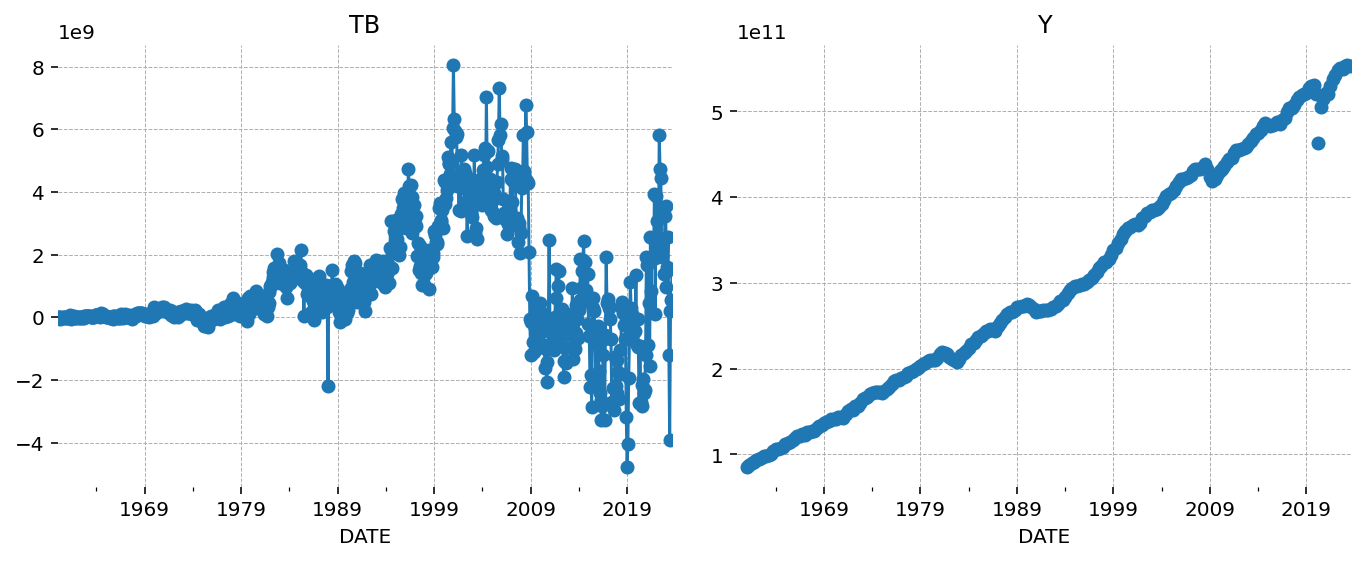

In [5]:
plot_df(df, marker='o', figsize=(14,4))

## Preprocessing

### Trade Balance
Unlike all standard macro variables in closed economy, trade balance can be negative. This makes it difficult to study percentage deviations from the steady-state value: if TB went from -1 to 1, how much is relative to initial value?

What we will work with is TB to GDP ratio, as seen in lecture. Since it is a fraction between 0 and 1, we will not study its change as a percentage of the s.s. value, but simply look at its change. So if $\frac{TB}{Y}$ went from -0.01 to 0.01, you will see a change of 0.02 on your graph.

In [6]:
import statsmodels.api as sm
TB_q = df.TB.resample('QS').sum()

In [7]:
df_q = df.Y.to_frame().join(TB_q).dropna(how='all')

In [8]:
TB_to_Y = df_q.TB / df_q.Y

### Others

These don't require additional comment -- see the baseline RBC notebook for details.

Note that we don't do a train/test split here -- you *ARE* required to do this no matter what final model you end up with. We omit it in this notebook to keep the focus on the special data treatments that result from working with the open economy model.

In [9]:
constant = np.ones_like(df_q.Y)
time = np.linspace(0, 1, df_q.Y.shape[0])
n_poly = 2

X = np.vstack([constant] + [time ** (i+1) for i in range(n_poly)]).T
names = ['intercept'] + [f'time^{i+1}' if i == 1 else 'time' for i in range(n_poly)]
X = pd.DataFrame(X, index=df_q.index, columns = names)

In [10]:
df_preprocessed = df_q.copy()
df_preprocessed['TBtoY'] = TB_to_Y
df_preprocessed.Y = df_preprocessed.Y.apply(np.log)

# detrend Y
mod = sm.OLS(df_preprocessed.Y, X, hasconst=True, missing='drop')
res = mod.fit()
df_preprocessed.Y = res.resid
df_preprocessed.drop(columns=['TB'], inplace=True)

In [11]:
ADF_test_summary(df_preprocessed, missing='drop')

                                                      Y                                                       
Specification               Coeff          Statistic     P-value      Lags      1%          5%        10%
--------------------------------------------------------------------------------------------------------------
Constant and Trend          -0.069         -3.418        0.049          0    -3.995      -3.428     -3.137
	Constant             0.002          1.052        0.294
	Trend               -0.000         -0.833        0.406
Constant Only               -0.069         -3.418        0.010          0    -3.457      -2.873     -2.573
	Constant             0.001          0.663        0.508
No Constant                 -0.069         -3.423        0.001          0    -2.575      -1.942     -1.616
                                                    TBtoY                                                     
Specification               Coeff          Statistic     P-value      La

# Load Model

## $IIP_{ss}$ Calibration (IIP_bar parameter)

To calibrate the steady state IIP, we have to do a little bit of work with both the data and the model. Actually, the IIP won't change the steady state GDP, so first we have to get the steady state GDP. Then we can combine that with the long-run average for the TB to Y ratio in the data to get a steady-state IIP. The key equation we will exploit is:

$$CA_t = TB_t + IIP_{t-1} r_{t-1}$$

We will set this to the steady state and divide both sides by $Y_{ss}$ to obtain:

$$0 = \frac{TB_{ss}}{Y_{ss}} + \frac{IIP_{ss}}{Y_{ss}}r_{ss}$$

In this equation, we will have some things as data, and others as model outcomes. In the future, it will be up to you as the economist to make the decision between these. For project, use the ratio $\frac{TB_{ss}}{Y_{ss}}$ from data, and use $Y_{ss}$ from the model. $r_{ss}$ you of course calibrated from data already, right? :)

In [12]:
# Load a baseline model
open_rbc = ge.gEconModel("../gcn_files/uribe_endo_r.gcn")

Model Building Complete.
Found:
	14 equations
	14 variables
	The following variables were eliminated at user request:
		U_t
	1 stochastic shock
		 0 / 1 has a defined prior. 
	11 parameters
		 0 / 11 has a defined prior. 
	0 calibrating equations
	0 parameters to calibrate
 Model appears well defined and ready to proceed to solving.



In [13]:
# Solve for steady state
open_rbc.steady_state()

Steady state found! Sum of squared residuals is 1.138752041299801e-18


In [14]:
# Pull out Y_ss and r_ss from the steady state
Y_zero = open_rbc.steady_state_dict['Y_ss']
r_ss = open_rbc.steady_state_dict['r_ss']

# Compute IIP_ss using the formula above
IIP_ss = -df_preprocessed.TBtoY.mean() / r_ss * Y_zero
IIP_ss

-11.66159065255465

In [15]:
# Set the new IIP_bar parameter
open_rbc.free_param_dict['IIPbar'] = IIP_ss

# Re-solve the steady-state
open_rbc.steady_state()

Steady state found! Sum of squared residuals is 1.2971442717964138e-18


Verify that IIP_ss = -IIP_bar

In [16]:
open_rbc.print_steady_state()

A_ss                1.000
CA_ss               0.000
C_ss                9.119
IIP_ss            -11.662
I_ss                2.736
K_ss              109.459
KtoN_ss            25.903
N_ss                4.226
TB_ss               0.117
TBtoY_ss            0.010
Y_ss               11.972
lambda_ss           0.081
r_given_ss          0.010
r_ss                0.010


## Solve the model

In [17]:
open_rbc.solve_model(not_loglin_variable=['CA', 'TB'])

Solution found, sum of squared residuals:  1.100779466603997e-28
Norm of deterministic part: 0.000000000
Norm of stochastic part:    0.000000000


In [18]:
irf = open_rbc.impulse_response_function(shock_size=0.03)

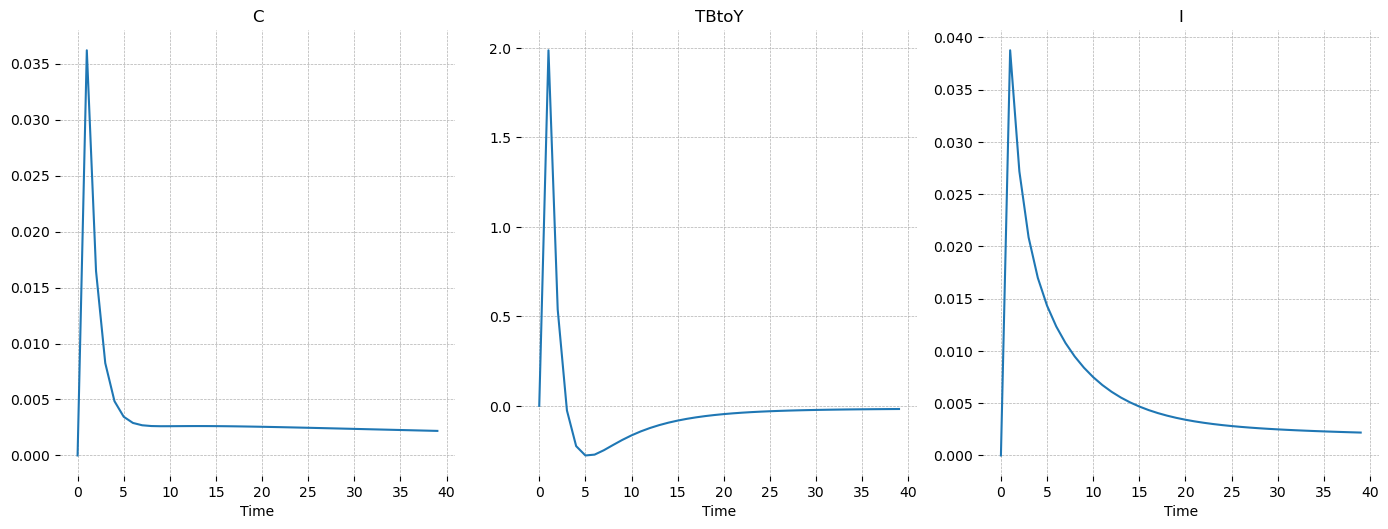

In [19]:
gp.plot_irf(irf, vars_to_plot=['C', 'TBtoY', 'I']);


In [20]:
mle_model = ge.compile_to_statsmodels(open_rbc)

In [27]:
from gEconpy.classes.transformers import PositiveTransformer, IntervalTransformer

param_start_dict = {
    "rho_A": 0.42,
}

shock_start_dict = {"epsilon_A": 0.1}
noise_start_dict = {'TBtoY':0.01}

# The slope parameter controls the steepness of the gradient around 0 (lower slope = more gentle gradient)
param_transforms = {
#     "psi2": PositiveTransformer(),
#     "sigma_L": IntervalTransformer(low=1.05, high=10.0, slope=1),
    "rho_A": IntervalTransformer(low=1e-4, high=0.99, slope=1),
    #     'alpha':IntervalTransformer(low=0.1, high=0.80, slope=1)
}

mle_mod = mle_model(
    df_preprocessed.dropna(),
    param_start_dict=param_start_dict,
    shock_start_dict=shock_start_dict,
    noise_start_dict=noise_start_dict,
    param_transforms=param_transforms,
    shock_transforms=None,  # If None, will automatically transform to positive values only
    noise_transforms=None,  # If None, will automatically transform to positive values only
    initialization="stationary",
    fit_MAP=False
)

/Users/jessegrabowski/mambaforge/envs/econ/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['constant', 'initial_state_cov']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


In [28]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    mle_res = mle_mod.fit(method="basinhopping", 
                          T=1, 
                          niter=10_000, 
                          niter_success=250, 
                          stepsize=0.1,
                          target_accept_rate=0.5,
                          minimizer={'method':'newton-cg'})


basinhopping step 0: f 1715.51
basinhopping step 1: f 481.762 trial_f 481.762 accepted 1  lowest_f 481.762
found new global minimum on step 1 with function value 481.762
basinhopping step 2: f 481.762 trial_f 944.723 accepted 0  lowest_f 481.762
basinhopping step 3: f 481.762 trial_f 1581.41 accepted 0  lowest_f 481.762
basinhopping step 4: f 179.763 trial_f 179.763 accepted 1  lowest_f 179.763
found new global minimum on step 4 with function value 179.763
basinhopping step 5: f 179.763 trial_f 255.785 accepted 0  lowest_f 179.763
basinhopping step 6: f 106.29 trial_f 106.29 accepted 1  lowest_f 106.29
found new global minimum on step 6 with function value 106.29
basinhopping step 7: f 106.29 trial_f 791.668 accepted 0  lowest_f 106.29
basinhopping step 8: f 40.3303 trial_f 40.3303 accepted 1  lowest_f 40.3303
found new global minimum on step 8 with function value 40.3303
basinhopping step 9: f 9.1975 trial_f 9.1975 accepted 1  lowest_f 9.1975
found new global minimum on step 9 with fu

basinhopping step 92: f -0.288041 trial_f -0.288041 accepted 1  lowest_f -1.64483
basinhopping step 93: f 0.220263 trial_f 0.220263 accepted 1  lowest_f -1.64483
basinhopping step 94: f 0.220263 trial_f 0.707832 accepted 0  lowest_f -1.64483
basinhopping step 95: f 0.225178 trial_f 0.225178 accepted 1  lowest_f -1.64483
basinhopping step 96: f 0.681279 trial_f 0.681279 accepted 1  lowest_f -1.64483
basinhopping step 97: f 0.866794 trial_f 0.866794 accepted 1  lowest_f -1.64483
basinhopping step 98: f 0.967525 trial_f 0.967525 accepted 1  lowest_f -1.64483
basinhopping step 99: f 0.681372 trial_f 0.681372 accepted 1  lowest_f -1.64483
adaptive stepsize: acceptance rate 0.660000 target 0.500000 new stepsize 0.123457 old stepsize 0.111111
basinhopping step 100: f 0.158562 trial_f 0.158562 accepted 1  lowest_f -1.64483
basinhopping step 101: f 0.762037 trial_f 0.762037 accepted 1  lowest_f -1.64483
basinhopping step 102: f 0.540514 trial_f 0.540514 accepted 1  lowest_f -1.64483
basinhoppin

basinhopping step 197: f 2.65305 trial_f 2.65305 accepted 1  lowest_f -1.64483
basinhopping step 198: f 2.5328 trial_f 2.5328 accepted 1  lowest_f -1.64483
basinhopping step 199: f 2.79743 trial_f 2.79743 accepted 1  lowest_f -1.64483
adaptive stepsize: acceptance rate 0.805000 target 0.500000 new stepsize 0.152416 old stepsize 0.137174
basinhopping step 200: f 2.52996 trial_f 2.52996 accepted 1  lowest_f -1.64483
basinhopping step 201: f 2.82792 trial_f 2.82792 accepted 1  lowest_f -1.64483
basinhopping step 202: f 2.91579 trial_f 2.91579 accepted 1  lowest_f -1.64483
basinhopping step 203: f 2.91579 trial_f 3.19853 accepted 0  lowest_f -1.64483
basinhopping step 204: f 2.6555 trial_f 2.6555 accepted 1  lowest_f -1.64483
basinhopping step 205: f 2.42376 trial_f 2.42376 accepted 1  lowest_f -1.64483
basinhopping step 206: f 2.73782 trial_f 2.73782 accepted 1  lowest_f -1.64483
basinhopping step 207: f 2.7725 trial_f 2.7725 accepted 1  lowest_f -1.64483
basinhopping step 208: f 2.68229 

In [29]:
mle_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:         ['Y', 'TBtoY']   No. Observations:                  251
Model:                      DSGEModel   Log Likelihood                -124.911
Date:                Sat, 23 Dec 2023   AIC                            255.821
Time:                        15:35:53   BIC                            266.398
Sample:                    01-01-1961   HQIC                           260.077
                         - 07-01-2023                                         
Covariance Type:                  opg                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
rho_A                0.4888      0.258      1.893      0.058      -0.017       0.995
sigma2.epsilon_A     0.0116      0.008      1.433      0.152      -0.004       0.028
sigma2.TBtoY         0.7313      0.522      1.400      0.161      -0.292       1.755
===================================================================================
Ljung-Box (L1) (Q):         125.20, 181.10   Jarque-Bera (JB):       444.08, 349.59
Prob(Q):                        0.00, 0.00   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         0.70, 1.01   Skew:                      -1.63, 1.45
Prob(H) (two-sided):            0.10, 0.97   Kurtosis:                   8.64, 8.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (centered finite differences).
"""

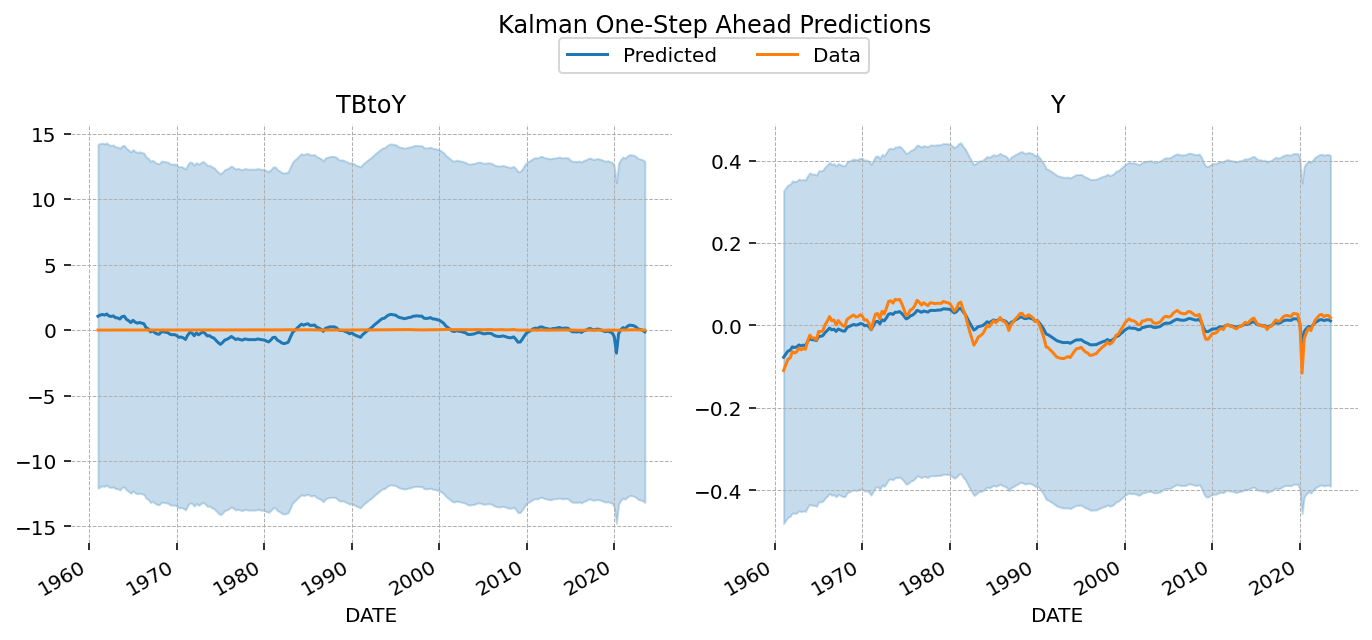

In [30]:
plot_sm_results(mle_res, extra_data=df_preprocessed, var_names=['Y', 'TBtoY'], figsize=(14,4), 
                filter_output='predicted')